# IEEE Fraud Detection Kaggle Competition

A somewhat reliable validation method has been found by splitting transactions into weeks and sampling weeks evenly (leaving out first and last week due to lack of samples), using a time series split of 5 folds with 1 week for testing and a 1 week delay, and validating against leaderboard (good correlation but not perfect).

In this notebook, we move on to exploring the most important features found from the baseline lightgbm model trained on (almost) all of the data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
pd.set_option('display.max_columns', 500)
num_folds = 5
SEED = 5000

In [3]:
train = pd.read_csv('../../output/merged_train.csv')
test = pd.read_csv('../../output/merged_test.csv')

In [4]:
sampled_train = pd.read_csv('../../output/sampled_train_by_week.csv')

In [6]:
categorical_features=['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                      'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
                      'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                      'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15',
                      'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
                      'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
                      'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
                      'id_37', 'id_38']

In [7]:
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')
    sampled_train[feature] = sampled_train[feature].astype('category')

In [8]:
important_features = pd.read_csv('../../output/lightgbm_importance.csv')

In [9]:
important_features.head(20)

,feature,importance
0,card1,7948
1,TransactionAmt,6099
2,addr1,3720
3,dist1,2994
4,card2,2285
5,D15,2256
6,D4,1574
7,D10,1485
8,id_02,1390
9,C13,1340


In [10]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [11]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,vis

# Unimportant features

In [12]:
important_features[important_features['importance'] == 0]

,feature,importance
407,V240,0
408,id_27,0
409,V120,0
410,V27,0
411,V325,0
412,V241,0
413,addr2,0
414,V107,0
415,V1,0
416,V89,0


Let's remove these features outright

In [14]:
# sampled_train = sampled_train.drop(important_features[important_features['importance'] == 0]['feature'].tolist(), axis=1)
# test = test.drop(important_features[important_features['importance'] == 0]['feature'].tolist(), axis=1)

In [15]:
# train.shape

# card exploration

In [16]:
card_features = ['card' + str(x) for x in range(1,7)]

In [17]:
train.loc[:,card_features].head(20)

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit
5,5937,555.0,150.0,visa,226.0,debit
6,12308,360.0,150.0,visa,166.0,debit
7,12695,490.0,150.0,visa,226.0,debit
8,2803,100.0,150.0,visa,226.0,debit
9,17399,111.0,150.0,mastercard,224.0,debit


card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

card4 is card type (found to be unimportant by baseline LightGBM and EDA showed that it probably wouldn't be important)

From data description: You may understand (addr1 and addr2) as billing zipcode and country. (It's not street address - which would cause too many levels). This must match the address that the credit card company has on file for that card, otherwise the transaction is likely fraudulent. By country for card, the country of issue is meant: "A card contains many information, including card category (credit, debit), card type (visa, mastercard, discover, etc), issue bank (Chase, Citi, etc) and issue country, etc. We encoded the real values due to data privacy."

Presumably if the country of issue matches up with addr2 it will not be adding any new information and this is probably usually the case for cases of non-fraud? 

Let's see if addr2 matches up with any of the codes in card2, card3, or card5, for the non-fraudulent transactions in order to figure out which of these are country of issue.

From below analysis, it looks like card3 is country of issue.

People in forums mentioned that card1 is issue bank.

Then card6 is card category. So in summary:

 - card1 - issuing bank
 - card2 - ?
 - card3 - country of issue
 - card4 - card type
 - card5 - ?
 - card6 - card category


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


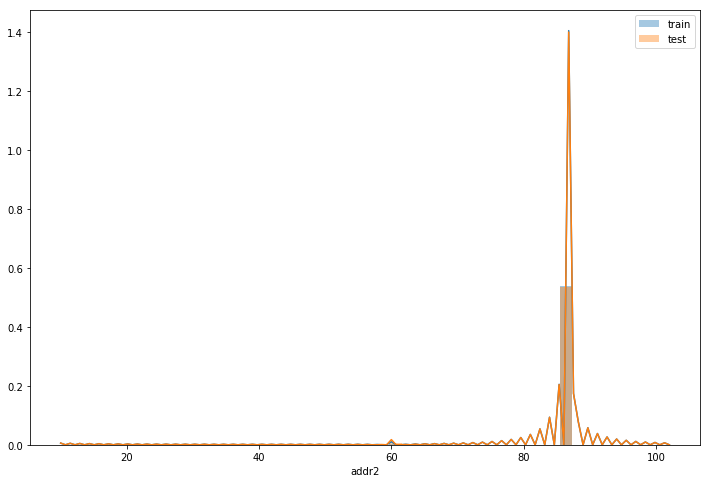

In [18]:
plt.figure(figsize=(12,8))
sns.distplot(train['addr2'], label='train')
sns.distplot(test['addr2'], label='test')
plt.legend()

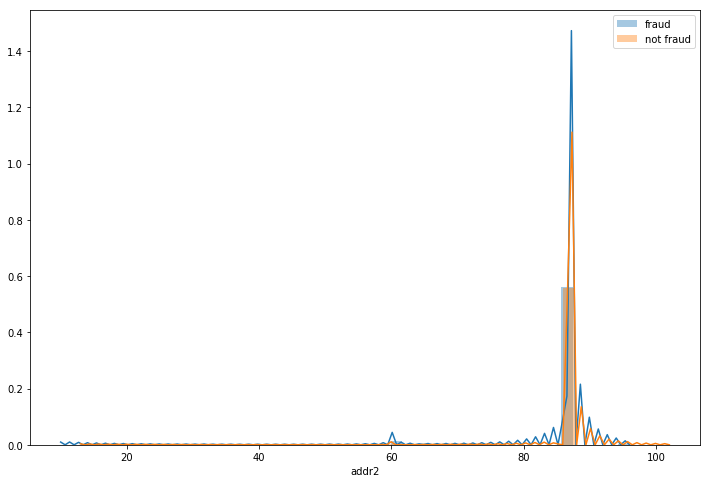

In [19]:
plt.figure(figsize=(12,8))
sns.distplot(train[(train['isFraud'] == 1) & (train['addr2'].notna())]['addr2'], label='fraud')
sns.distplot(train[(train['isFraud'] == 0) & (train['addr2'].notna())]['addr2'], label='not fraud')
plt.legend()

No surprise as to this being a useless feature

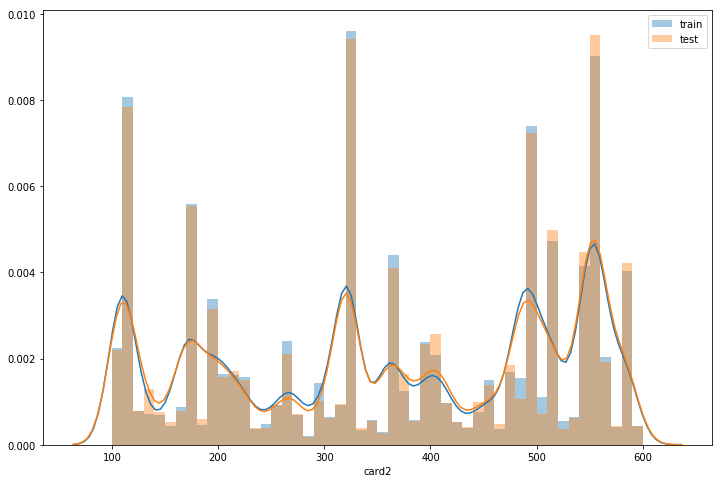

In [20]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['card2'].notna()]['card2'], label='train')
sns.distplot(test[test['card2'].notna()]['card2'], label='test')
plt.legend()

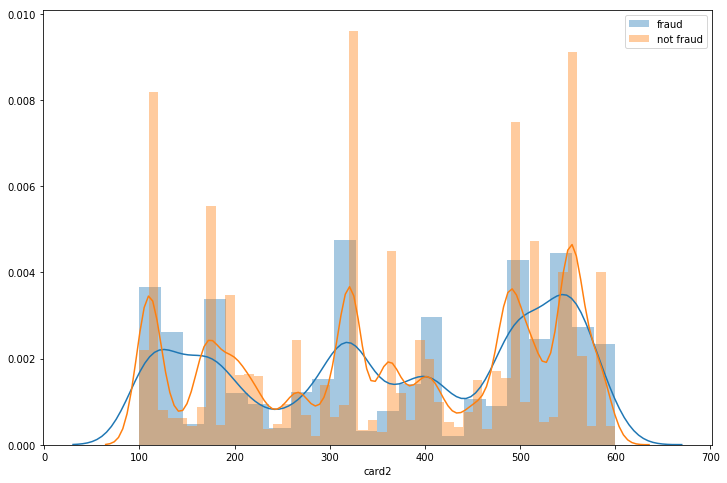

In [21]:
plt.figure(figsize=(12,8))
sns.distplot(train[(train['isFraud'] == 1) & (train['card2'].notna())]['card2'], label='fraud')
sns.distplot(train[(train['isFraud'] == 0) & (train['card2'].notna())]['card2'], label='not fraud')
plt.legend()

Text(0.5, 1.0, 'card2 vs. addr2 train')

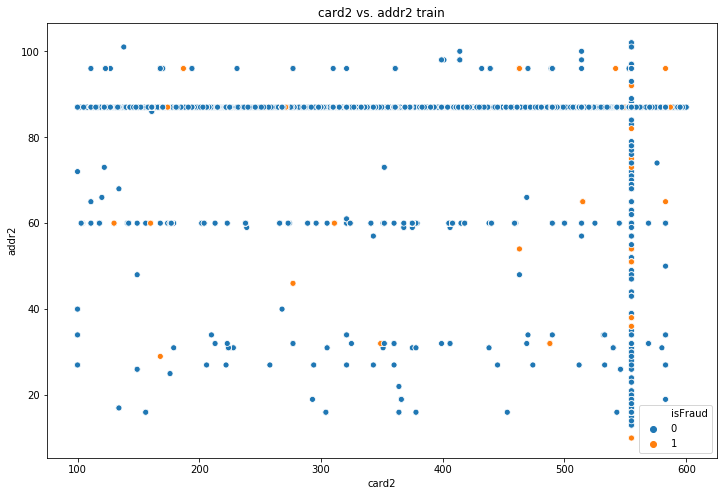

In [22]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='card2', y='addr2', data=train, hue='isFraud')
plt.title('card2 vs. addr2 train')

<Figure size 864x576 with 0 Axes>

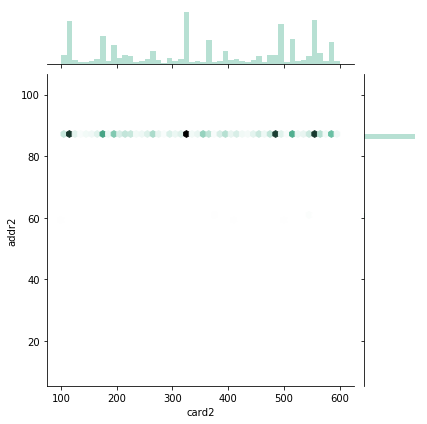

In [23]:
plt.figure(figsize=(12,8))
sns.jointplot('card2', 'addr2', data=train, kind="hex", color="#4CB391")

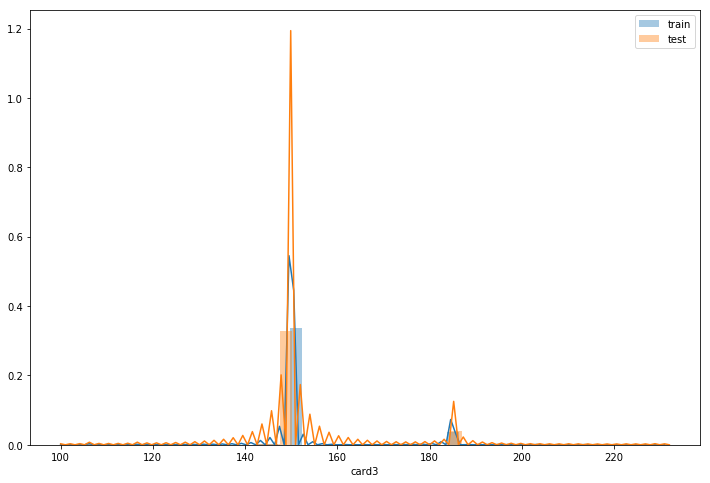

In [24]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['card3'].notna()]['card3'], label='train')
sns.distplot(test[test['card3'].notna()]['card3'], label='test')
plt.legend()

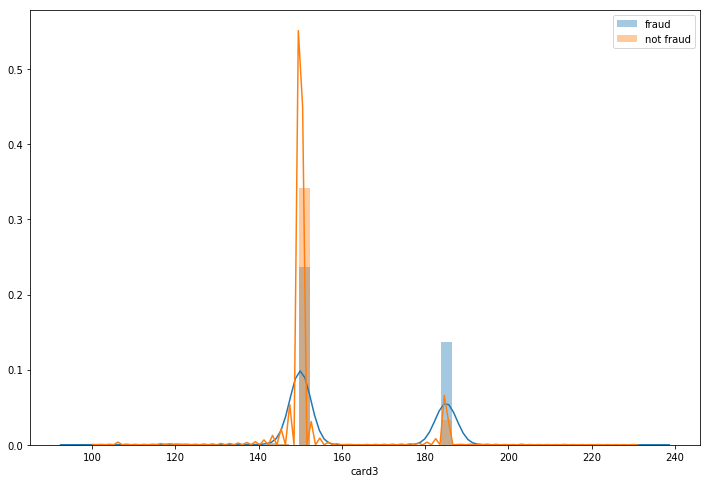

In [25]:
plt.figure(figsize=(12,8))
sns.distplot(train[(train['isFraud'] == 1) & (train['card3'].notna())]['card3'], label='fraud')
sns.distplot(train[(train['isFraud'] == 0) & (train['card3'].notna())]['card3'], label='not fraud')
plt.legend()

Text(0.5, 1.0, 'card3 vs. addr2 train')

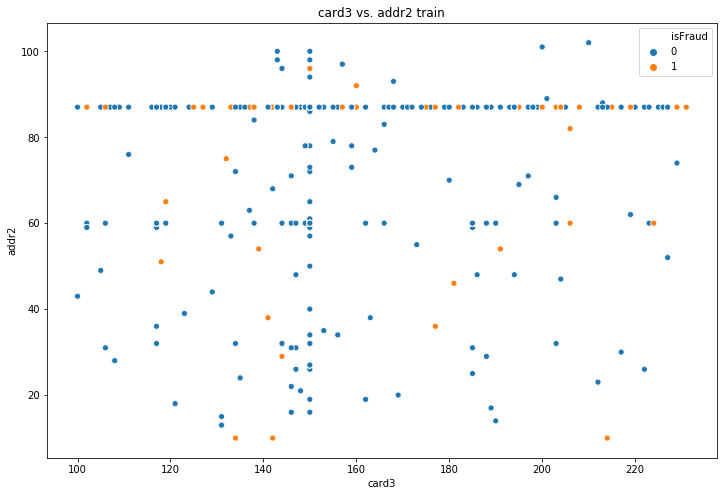

In [26]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='card3', y='addr2', data=train, hue='isFraud')
plt.title('card3 vs. addr2 train')

<Figure size 864x576 with 0 Axes>

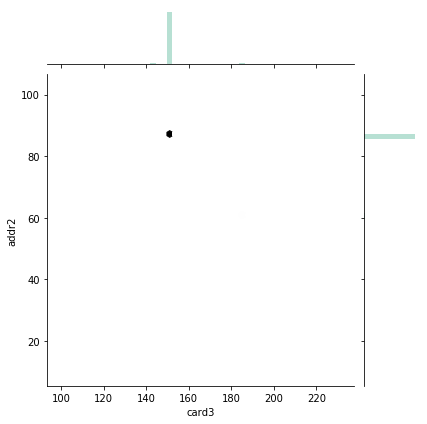

In [27]:
plt.figure(figsize=(12,8))
sns.jointplot('card3', 'addr2', data=train, kind="hex", color="#4CB391")

In [28]:
train['card3'].value_counts().head(10)

150.0    521287
185.0     56346
106.0      1571
146.0      1252
144.0      1252
117.0       962
143.0       899
119.0       750
102.0       460
147.0       390
Name: card3, dtype: int64

Looks like a lot of the concurrent card3 values at 150 have an addr2 value of 87 - this is probably country of issue

In [29]:
print('{:.0f}% of train'.format(train[(train['card3'] == 150) & (train['addr2'] == 87)].shape[0] / len(train) * 100))

88% of train


In [30]:
train[(train['card3'] != 150) & (train['addr2'] == 87) & (train['card3'].notna())].shape

(1548, 434)

In [31]:
train[(train['card3'] == 150) & (train['addr2'] != 87)& (train['addr2'].notna())].shape

(166, 434)

Only 166 rows where card3 is 150 and addr2 is not 87 and only 1548 rows where card3 is not 150 and addr2 is 87 - presumably these have a decent amount of fraud?

In [32]:
train[(train['card3'] != 150) & (train['addr2'] == 87) & (train['card3'].notna())]['isFraud'].value_counts()

0    1431
1     117
Name: isFraud, dtype: int64

In [33]:
117/1431 * 100

8.176100628930817

In [34]:
train[(train['card3'] == 150) & (train['addr2'] != 87) & (train['addr2'].notna())]['isFraud'].value_counts()

0    147
1     19
Name: isFraud, dtype: int64

In [35]:
19/147 * 100

12.925170068027212

8% and 13% of these rows are fraudulent. Much higher than the ratio of fraudulent transactions to non-fraud in the entire dataset

In [36]:
train['addr2'].isna().value_counts()

False    524834
True      65706
Name: addr2, dtype: int64

In [37]:
train['addr2'].value_counts().head()

87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
Name: addr2, dtype: int64

In [38]:
train['card3'].value_counts().head()

150.0    521287
185.0     56346
106.0      1571
146.0      1252
144.0      1252
Name: card3, dtype: int64

In [39]:
test['addr2'].value_counts().head()

87.0    435934
60.0      4041
96.0       608
32.0        61
65.0        49
Name: addr2, dtype: int64

In [40]:
test['card3'].value_counts().head()

150.0    435558
185.0     53614
106.0      1972
117.0      1879
144.0      1381
Name: card3, dtype: int64

A feature that is 0 when card3 and addr2 match and 1 otherwise could be useful? Seems 87 for addr2 == 150 for card3. What about 60 for addr2?

<Figure size 864x576 with 0 Axes>

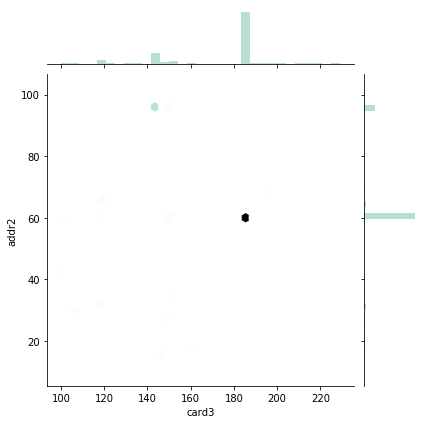

In [41]:
plt.figure(figsize=(12,8))
sns.jointplot('card3', 'addr2', data=train[train['addr2'] != 87], kind="hex", color="#4CB391")

185 for card3 appears to be 60 for addr2

<Figure size 864x576 with 0 Axes>

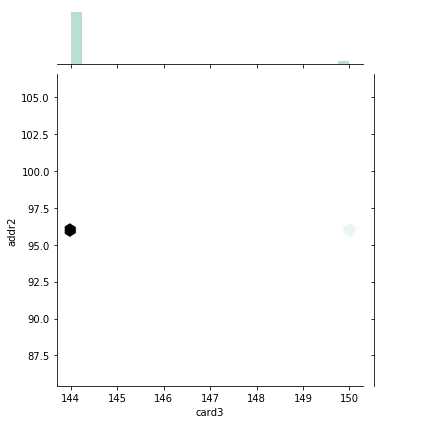

In [42]:
plt.figure(figsize=(12,8))
sns.jointplot('card3', 'addr2', data=train[train['addr2'] == 96.0], kind="hex", color="#4CB391")

card3 144 == addr2 96

<Figure size 864x576 with 0 Axes>

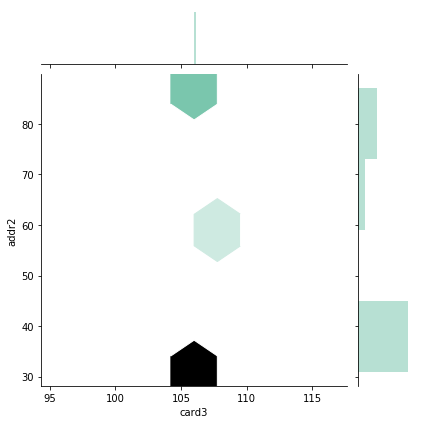

In [43]:
plt.figure(figsize=(12,8))
sns.jointplot('card3', 'addr2', data=train[train['card3'] == 106], kind="hex", color="#4CB391")

Might be addr2 32 == card3 106

<Figure size 864x576 with 0 Axes>

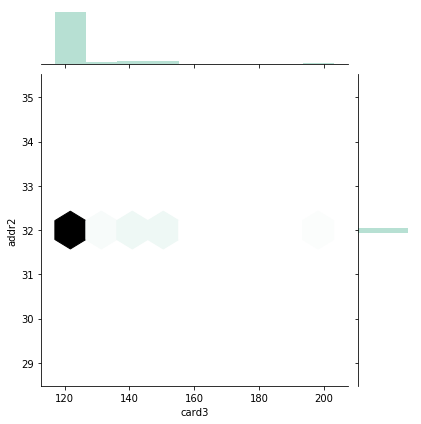

In [44]:
plt.figure(figsize=(12,8))
sns.jointplot('card3', 'addr2', data=train[train['addr2'] == 32], kind="hex", color="#4CB391")

Lets try addr2 = 31

<Figure size 864x576 with 0 Axes>

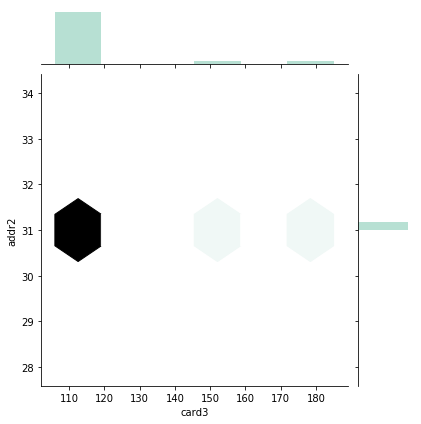

In [45]:
plt.figure(figsize=(12,8))
sns.jointplot('card3', 'addr2', data=train[train['addr2'] == 31], kind="hex", color="#4CB391")

Difficult to say. Here's what we can be confident in:

addr2 - card3

 - 87 - 150
 - 60 - 185
 - 96 - 144 

In [46]:
train[((train['card3'] == 150) & (train['addr2'] == 87))
      | ((train['card3'] == 185) & (train['addr2'] == 60))
      | ((train['card3'] == 144) & (train['addr2'] == 96))][['M' + str(x) for x in range(1,10)]].head(20)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,T,T,T,M1,F,T,NaN,NaN,NaN
6,T,T,T,M0,F,F,T,T,T
7,NaN,NaN,NaN,M0,F,F,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,T,T,T,M0,T,T,NaN,NaN,NaN


In [47]:
train[((train['card3'] == 150) & (train['addr2'] == 87))
      | ((train['card3'] == 185) & (train['addr2'] == 60))
      | ((train['card3'] == 144) & (train['addr2'] == 96))]['M1'].value_counts()

T    317231
F        21
Name: M1, dtype: int64

In [48]:
train[((train['card3'] == 150) & (train['addr2'] == 87))
      | ((train['card3'] == 185) & (train['addr2'] == 60))]['M1'].value_counts()

T    317219
F        21
Name: M1, dtype: int64

In [49]:
train[((train['card3'] == 150) & (train['addr2'] == 87))]['M1'].value_counts()

T    317219
F        21
Name: M1, dtype: int64

Looks like M1 is a feature detailing if card3 and addr2 match but the small amount of False values here are weird. Could this mean that there is an equivalent for addr1 somewhere in the card features and M1 details if the complete addresses match? My guess is on card2

In [50]:
train[['card2', 'addr1']].head(10)

,card2,addr1
0,NaN,315.0
1,404.0,325.0
2,490.0,330.0
3,567.0,476.0
4,514.0,420.0
5,555.0,272.0
6,360.0,126.0
7,490.0,325.0
8,100.0,337.0
9,111.0,204.0


In [51]:
train['card2'].value_counts().head()

321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
Name: card2, dtype: int64

In [52]:
train['addr1'].value_counts().head()

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
Name: addr1, dtype: int64

<Figure size 864x576 with 0 Axes>

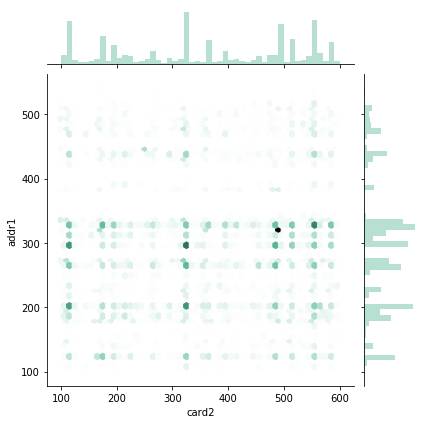

In [53]:
plt.figure(figsize=(12,8))
sns.jointplot('card2', 'addr1', data=train, kind="hex", color="#4CB391")

In [54]:
train[(train['card2'] == 321) & (train['addr1'] == 299)].shape

(7365, 434)

In [55]:
train[(train['card2'] == 321) & (train['addr1'] == 325)].shape

(800, 434)

In [56]:
train[(train['card2'] == 321) & (train['addr1'] == 204)].shape

(5783, 434)

In [57]:
train[(train['card2'] == 321) & (train['addr1'] == 264)].shape

(4919, 434)

In [58]:
train[(train['card2'] == 321) & (train['addr1'] == 330)].shape

(2247, 434)

<Figure size 864x576 with 0 Axes>

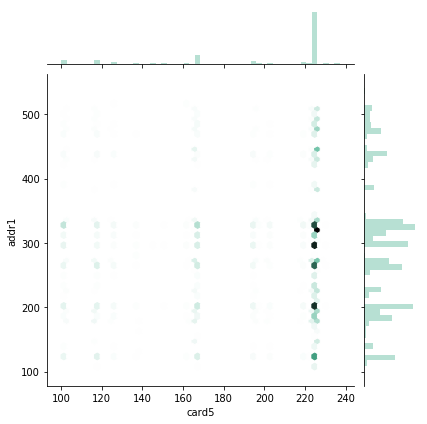

In [59]:
plt.figure(figsize=(12,8))
sns.jointplot('card5', 'addr1', data=train, kind="hex", color="#4CB391")

In [66]:
train['card5'].value_counts().head()

226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
Name: card5, dtype: int64

<Figure size 864x576 with 0 Axes>

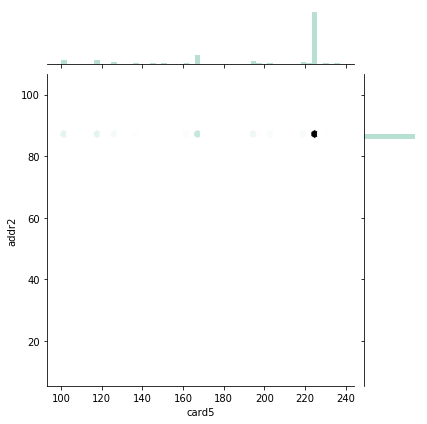

In [60]:
plt.figure(figsize=(12,8))
sns.jointplot('card5', 'addr2', data=train, kind="hex", color="#4CB391")

Maybe not. How important is M1?

In [61]:
important_features[important_features['feature'] == 'M1']

,feature,importance
269,M1,21


In [62]:
important_features[important_features['feature'] == 'card3']

,feature,importance
168,card3,53


In [63]:
important_features[important_features['feature'] == 'addr2']

,feature,importance
413,addr2,0


Not very. Maybe we can create a better M1 feature and drop M1, addr2, and card2?

In [64]:
train['M1'].isna().value_counts()

False    319440
True     271100
Name: M1, dtype: int64

Missing a lot of values though

addr2 - card3

 - 87 - 150
 - 60 - 185
 - 96 - 144 

In [68]:
(((train['card3'] == 150) & (train['addr2'] == 87)) | ((train['card3'] == 185) & (train['addr2'] == 60)) | (
    (train['card3'] == 144) & (train['addr2'] == 96))).value_counts()

True     521126
False     69414
dtype: int64

In [69]:
(((train['card3'] == 150) & (train['addr2'] == 87)) | ((train['card3'] == 185) & (train['addr2'] == 60)) | (
    (train['card3'] == 144) & (train['addr2'] == 96))).head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

Some should be NaN

In [76]:
temp_df = pd.concat([train[['card3', 'addr2']], test[['card3', 'addr2']]])
temp_df['country_match'] = np.nan
temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] == 87),
                                    1,
                                    temp_df['country_match'])
temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] != 87),
                                    1,
                                    temp_df['country_match'])
temp_df['country_match'] = np.where((temp_df['card3'] != 150) & (temp_df['addr2'] == 87),
                                    1,
                                    temp_df['country_match'])

temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] == 60),
                                    1,
                                    temp_df['country_match'])
temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] != 60),
                                    0,
                                    temp_df['country_match'])
temp_df['country_match'] = np.where((temp_df['card3'] != 185) & (temp_df['addr2'] == 60),
                                    0,
                                    temp_df['country_match'])

temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] == 96),
                                    1,
                                    temp_df['country_match'])
temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] != 96),
                                    0,
                                    temp_df['country_match'])
temp_df['country_match'] = np.where((temp_df['card3'] != 144) & (temp_df['addr2'] == 96),
                                    0,
                                    temp_df['country_match'])
# temp_df = temp_df.dropna()
# fq_encode = temp_df[col].value_counts().to_dict()   
# sampled_train[col] = sampled_train[col].map(fq_encode)

In [79]:
temp_df

,card3,addr2,country_match
0,150.0,87.0,1.0
1,150.0,87.0,1.0
2,150.0,87.0,1.0
3,150.0,87.0,1.0
4,150.0,87.0,1.0
5,150.0,87.0,1.0
6,150.0,87.0,1.0
7,150.0,87.0,1.0
8,150.0,87.0,1.0
9,150.0,87.0,1.0


In [ ]:
train['M1'] = ((train['card3'] == 150) & (train['addr2'] == 87)) | ((train['card3'] == 185) & (train['addr2'] == 60)) | (
                (train['card3'] == 144) & (train['addr2'] == 96))

In [ ]:
train['M1']

Repeating a similar analysis for card5

In [90]:
train['card5'].value_counts().head()

226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
Name: card5, dtype: int64

In [91]:
print('{:.0f}% of train'.format(train[(train['card5'] == 226) & (train['addr2'] == 87)].shape[0] / len(train) * 100))

48% of train


In [95]:
print('{:.0f}% of train'.format(train[(train['card5'] == 224) & (train['addr2'] == 87)].shape[0] / len(train) * 100))

10% of train


In [105]:
train[(train['card5'] != 226) & (train['addr2'] == 87) & (train['card5'].notna())].shape

(232696, 434)

In [92]:
train[(train['card5'] == 226) & (train['addr2'] != 87) & (train['addr2'].notna())].shape

(924, 434)

In [106]:
train[(train['card5'] != 226) & (train['addr2'] == 87) & (train['card5'].notna())]['isFraud'].value_counts()

0    227442
1      5254
Name: isFraud, dtype: int64

In [93]:
train[(train['card5'] == 226) & (train['addr2'] != 87) & (train['addr2'].notna())]['isFraud'].value_counts()

0    772
1    152
Name: isFraud, dtype: int64

In [107]:
5254 / 227442 * 100

2.3100394825933646

In [94]:
152 / 772 * 100

19.689119170984455

So what are card2 and card5?

In [109]:
important_features[important_features['feature'] == 'card2']

,feature,importance
4,card2,2285


In [108]:
important_features[important_features['feature'] == 'card5']

,feature,importance
72,card5,180


In [28]:
train.loc[:,['card' + str(x) for x in range(1,7)]].head(20)

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit
5,5937,555.0,150.0,visa,226.0,debit
6,12308,360.0,150.0,visa,166.0,debit
7,12695,490.0,150.0,visa,226.0,debit
8,2803,100.0,150.0,visa,226.0,debit
9,17399,111.0,150.0,mastercard,224.0,debit


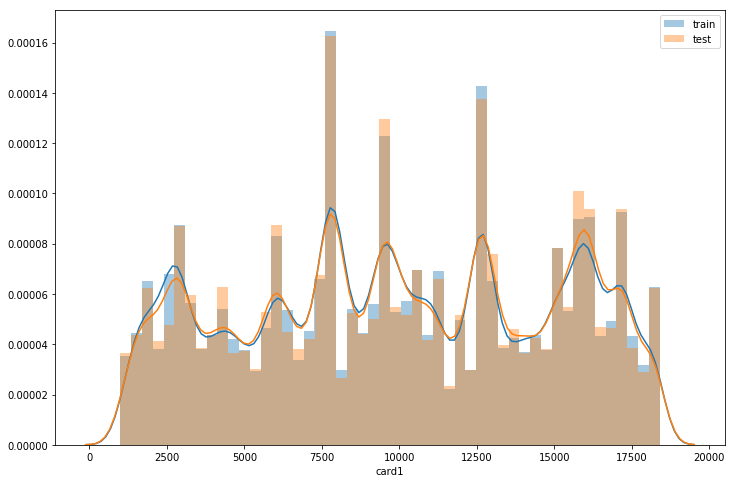

In [29]:
plt.figure(figsize=(12,8))
sns.distplot(train['card1'], label='train')
sns.distplot(test['card1'], label='test')
plt.legend()

Near identically distributed between datasets

In [30]:
train['card1'].isna().value_counts()

False    590540
Name: card1, dtype: int64

In [31]:
test['card1'].isna().value_counts()

False    506691
Name: card1, dtype: int64

We know from the competition setup that card1 is a categorical feature

In [32]:
train['card1'].dtype

CategoricalDtype(categories=[ 1000,  1001,  1004,  1005,  1006,  1007,  1008,  1009,
                   1010,  1011,
                  ...
                  18383, 18384, 18385, 18387, 18388, 18390, 18391, 18393,
                  18395, 18396],
                 ordered=False)

In [33]:
test['card1'].dtype

CategoricalDtype(categories=[ 1001,  1002,  1003,  1004,  1005,  1006,  1007,  1008,
                   1009,  1012,
                  ...
                  18387, 18389, 18390, 18391, 18392, 18393, 18394, 18395,
                  18396, 18397],
                 ordered=False)

In [34]:
train['card1'] = train['card1'].astype('category')
test['card1'] = test['card1'].astype('category')

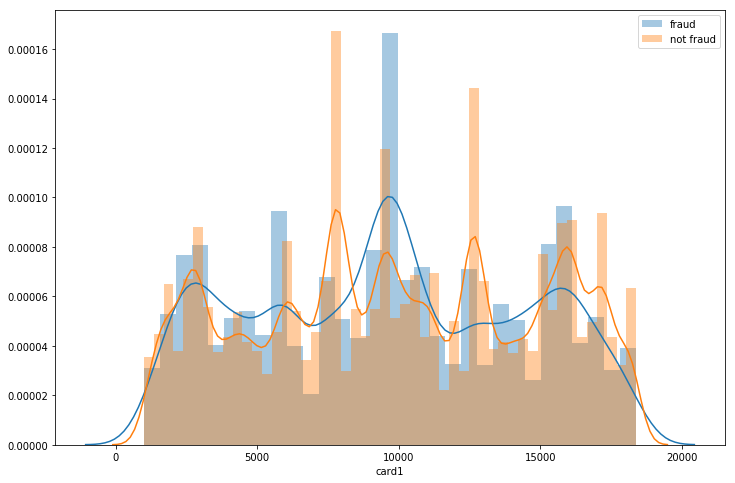

In [35]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['isFraud'] == 1]['card1'], label='fraud')
sns.distplot(train[train['isFraud'] == 0]['card1'], label='not fraud')
plt.legend()

In [36]:
card1_df = pd.DataFrame(data={'card1': train['card1'], 'isFraud': train['isFraud']})

In [37]:
card1_df.head()

,card1,isFraud
0,13926,0
1,2755,0
2,4663,0
3,18132,0
4,4497,0


In [38]:
from scipy.stats import chi2_contingency

In [39]:
control = train[train['isFraud'] == 0]['card1'].value_counts().sort_index().values

In [40]:
case = train[train['isFraud'] == 1]['card1'].value_counts().sort_index().values

In [41]:
obs = np.array([control, case]).T

In [42]:
control

array([ 1,  3,  5, ...,  3, 11,  1])

In [43]:
case

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
obs

array([[ 1,  0],
       [ 3,  0],
       [ 5,  0],
       ...,
       [ 3,  0],
       [11,  0],
       [ 1,  0]])

In [45]:
len(case)

13553

In [46]:
obs.shape

(13553, 2)

In [47]:
dof = (len(case) - 1)*(obs.shape[1] - 1)

In [48]:
dof

13552

In [49]:
chi2_contingency(obs)

(72289.32601199143, 0.0, 13552, array([[ 0.96500999,  0.03499001],
        [ 2.89502997,  0.10497003],
        [ 4.82504995,  0.17495005],
        ...,
        [ 2.89502997,  0.10497003],
        [10.6151099 ,  0.3848901 ],
        [ 0.96500999,  0.03499001]]))

p-value of 0 meaning this result is statistically significant and we can reject the null hypothesis that the observed distribution is the result of random data

In [50]:
train.loc[:,['card' + str(x) for x in range(1,7)]].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


card4 was dropped as an unimportant feature, this was the card type (Visa, Mastercard, Am Express, Discover or NaN). As we saw in our EDA, this feature didn't have much difference between the value counts for fraud and non-fraud between Visa, Mastercard, and NaN. Leading me to believe it wasn't going to be an important feature. It should be noted that Discover and American Express combined with the fact that all transaction amounts are in dollars means that most, if not all, of these transactions occured in the U.S.? However, their being online transactions means that these cards could have been stolen from the U.S. and used elsewhere. addr2 is country code?

In [51]:
train.loc[:,['card1', 'card2', 'card3', 'card5', 'card6']].head(10)

,card1,card2,card3,card5,card6
0,13926,NaN,150.0,142.0,credit
1,2755,404.0,150.0,102.0,credit
2,4663,490.0,150.0,166.0,debit
3,18132,567.0,150.0,117.0,debit
4,4497,514.0,150.0,102.0,credit
5,5937,555.0,150.0,226.0,debit
6,12308,360.0,150.0,166.0,debit
7,12695,490.0,150.0,226.0,debit
8,2803,100.0,150.0,226.0,debit
9,17399,111.0,150.0,224.0,debit


In [52]:
train['card2'].isna().value_counts()

False    581607
True       8933
Name: card2, dtype: int64

In [53]:
test['card2'].isna().value_counts()

False    498037
True       8654
Name: card2, dtype: int64

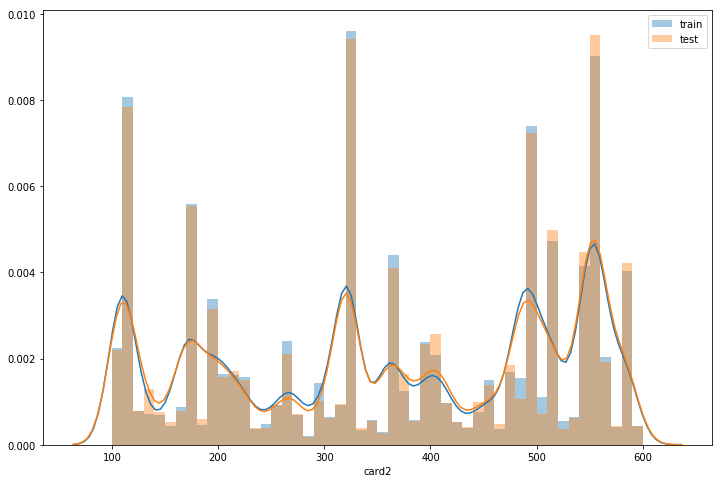

In [54]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['card2'].notna()]['card2'], label='train')
sns.distplot(test[test['card2'].notna()]['card2'], label='test')
plt.legend()

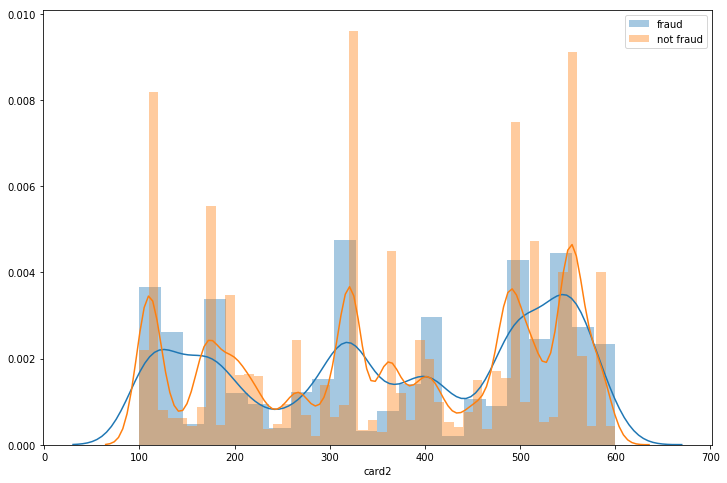

In [55]:
plt.figure(figsize=(12,8))
sns.distplot(train[(train['isFraud'] == 1) & (train['card2'].notna())]['card2'], label='fraud')
sns.distplot(train[(train['isFraud'] == 0) & (train['card2'].notna())]['card2'], label='not fraud')
plt.legend()

Big deviations between fraud and not fraud - can seee why this is  an important feature - model is supposedly picking out the bump in card2 at 550. Let's balance the target and pick out a few samples to train a tree on

In [56]:
train[train['card2'].notna()]['isFraud'].value_counts()

0    561367
1     20240
Name: isFraud, dtype: int64

In [57]:
balanced_df = train[(train['card2'].notna()) & (train['isFraud']==0)].sample(train[train['card2'].notna()]['isFraud'].value_counts()[1])

In [58]:
balanced_df = balanced_df.append(train[(train['card2'].notna()) & (train['isFraud']==1)].sample(train[train['card2'].notna()]['isFraud'].value_counts()[1]))

In [59]:
balanced_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
562324,3549324,0,14908066,69.000,W,10057,225.0,150.0,mastercard,224.0,debit,315.0,87.0,10.0,NaN,yahoo.com,NaN,6.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,29.0,6.0,68.0,68.0,1.0,526.0,1.0,NaN,NaN,NaN,NaN,142.0,207.0,NaN,NaN,NaN,526.0,T,T,T,M1,F,F,F,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,2.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0,196.000000,82.0,25.0,196.000000,82.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,1.0,5.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0,253.000000,82.0,25.0,253.000000,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103411,3090411,0,2064034,28.858,C,15885,545.0,185.0,visa,138.0,debit,NaN,NaN,NaN

In [60]:
balanced_df.shape

(40480, 434)

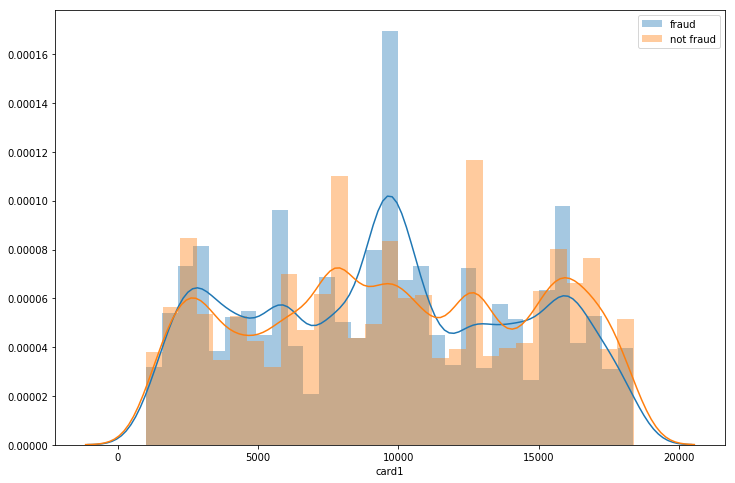

In [61]:
plt.figure(figsize=(12,8))
sns.distplot(balanced_df[balanced_df['isFraud'] == 1]['card1'], label='fraud')
sns.distplot(balanced_df[balanced_df['isFraud'] == 0]['card1'], label='not fraud')
plt.legend()

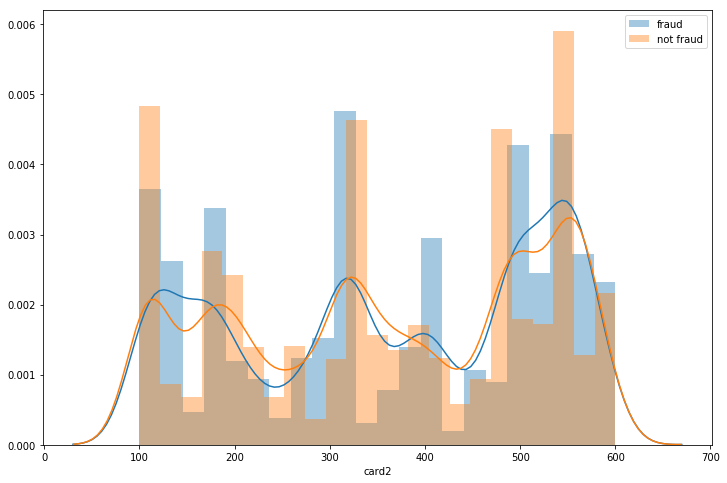

In [62]:
plt.figure(figsize=(12,8))
sns.distplot(balanced_df[balanced_df['isFraud'] == 1]['card2'], label='fraud')
sns.distplot(balanced_df[balanced_df['isFraud'] == 0]['card2'], label='not fraud')
plt.legend()

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [64]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=2)

In [65]:
tree_fit = tree_obj.fit(balanced_df[['card1','card2']],balanced_df['isFraud'].values)

In [66]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['card1', 'card2'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

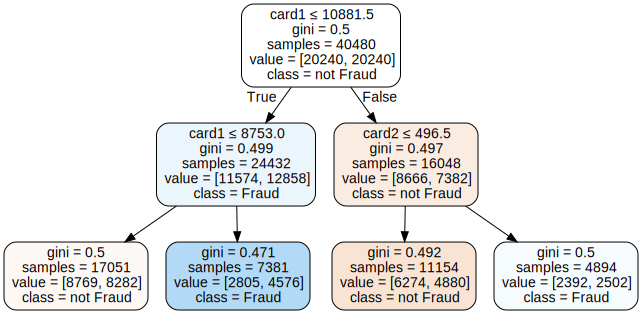

In [67]:
graph

Tree is clearly picking out these "bumps" of fraud in the distributions of the two features. Can something similar reveal anything about card2, card3, card5, and addr2?

# TransactionAmt

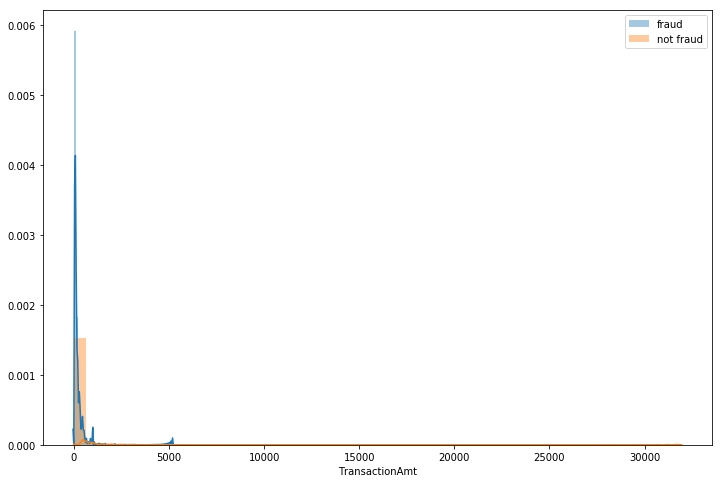

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['isFraud'] == 1]['TransactionAmt'], label='fraud')
sns.distplot(train[train['isFraud'] == 0]['TransactionAmt'], label='not fraud')
plt.legend()

In [7]:
transaction_df = pd.DataFrame(data={'TransactionAmt': train['TransactionAmt'],
                                    'isFraud': train['isFraud']})

In [10]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=2)

In [11]:
tree_fit = tree_obj.fit(transaction_df.drop('isFraud',axis=1),transaction_df['isFraud'].values)

In [12]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['TransactionAmt'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

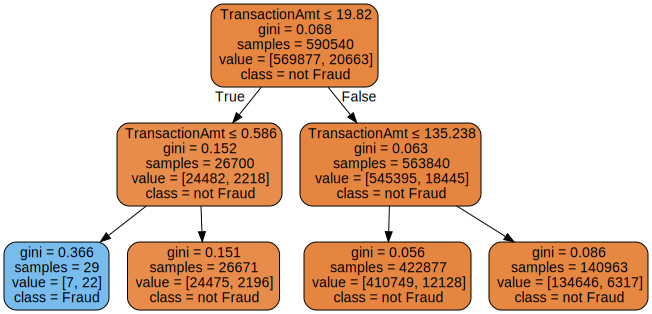

In [13]:
graph

Fraud committed in small amounts it looks like